# ETF Picking

#### Simple 12M momentum (ex-last month) strategy.

It has been shown empirically that assets that have performed best on the last 12 months tend to keep on performing during the next 3-4 month periods. When implementing this strategy we should remove the last month to eliminate bias due to short-term reversion effect.

The estimation universe consist on the cheapest set of ETFs covering the mayor global markets and most liquid U.S. sectors.


  
|Asset Class             |Primary ETF|Vendor      |Underlying Index                                     |Expense Ratio|
|------------------------|-----------|------------|-----------------------------------------------------|-------------|
|U.S. Stocks             |VTI        |Vanguard    |CRSP US Total Market Index                           |0.04%        |
|Foreign Stocks          |VEA        |Vanguard    |FTSE Developed All Cap ex US Index                   |0.07%        |
|Emerging Markets        |VWO        |Vanguard    |FTSE Emerging Markets All Cap China A Inclusion Index|0.14%        |
|Real Estate             |VNQ        |Vanguard    |MSCI US REIT                                         |0.12%        |
|Natural Resources       |XLE        |State Street|S&P Energy Select Sector Index                       |0.14%        |
|U.S. Government Bonds   |BND        |Vanguard    |Barclays Aggregate Bond                              |0.05%        |
|TIPS                    |SCHP       |Schwab      |Barclays Capital U.S. TIPS                           |0.05%        |
|Municipal Bonds         |VTEB       |Vanguard    |S&P National Municipal                               |0.09%        |
|Dividend Stocks         |VIG        |Vanguard    |Dividend Achievers Select                            |0.09%        |


In [1]:
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('Paired', 10))

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 16})
palette = sns.color_palette()

pd.options.mode.chained_assignment = None

In [2]:
## Read files and calculate returns.
files = glob.glob("*.csv")
dfs = []
for f in files:
    if 'etf' in f:
        continue
    df = pd.read_csv(f ,index_col=None, header=0)
    df.sort_values('Date', inplace=True)
    df['ret'] = df['Close'].pct_change()
    df = df[df['Date'] > '20161008']
    df['cum_ret'] = (1 + df['ret']).cumprod() - 1
    df['name'] = f.split('.')[0]
    dfs.append(df)
    
dfs = pd.concat(dfs)
dfs.columns = [col.lower() for col in df.columns]
dfs['date'] = pd.to_datetime(dfs['date'])

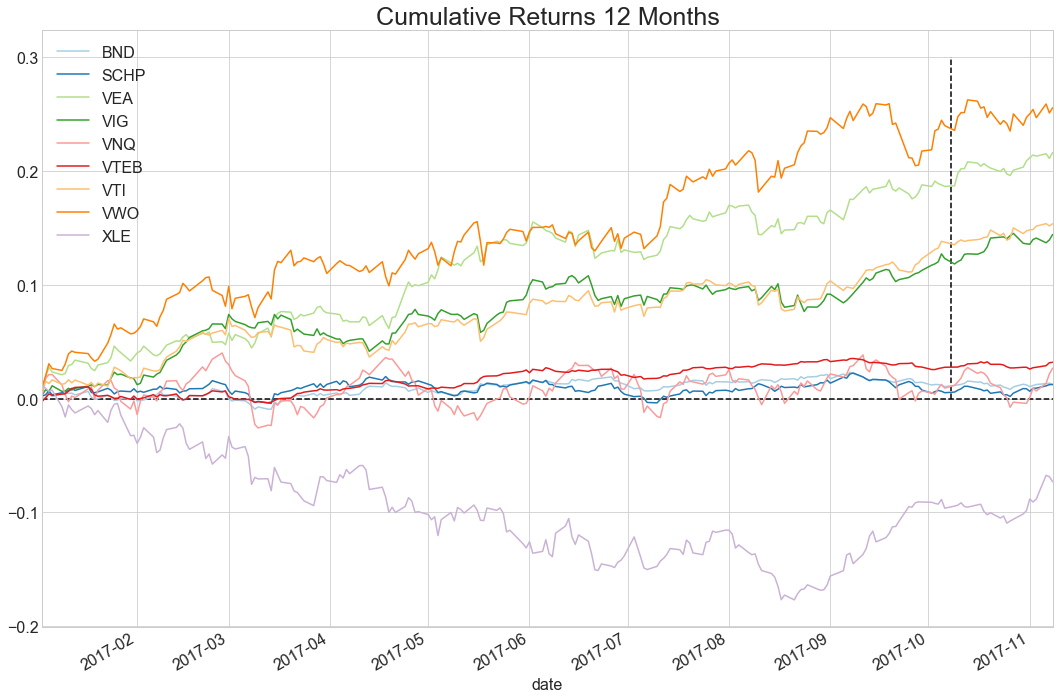

In [3]:
## Cumulative returns.
fig, ax = plt.subplots()
for name, data in dfs.groupby('name'):
    data.set_index('date')['cum_ret'].plot(ax=ax, alpha=1, label=name)
    
ax.legend()
ax.hlines(0, data['date'].min(), data['date'].max(), linestyle='dashed')
ax.vlines('20171008', 0, 0.3, linestyle='dashed')
ax.set_title('Cumulative Returns 12 Months', size=25)
fig.tight_layout()

Picks: VWO, VEA, VTI, VIG, VTEB
Average monthly return: 1.50%.


,index,date,open,high,low,close,adj close,volume,ret,cum_ret,name
0,3167,2017-10-06,44.209999,44.369999,44.070000,44.369999,44.369999,15506500,-0.003817,0.240078,VWO
1,2569,2017-10-06,43.250000,43.369999,43.189999,43.360001,43.360001,5228100,-0.001152,0.186645,VEA
2,4103,2017-10-06,131.059998,131.229996,130.910004,131.190002,131.190002,1635000,-0.000686,0.137617,VTI
3,2879,2017-10-06,95.760002,95.970001,95.529999,95.680000,95.680000,350400,-0.003645,0.123268,VIG
4,534,2017-10-06,51.560001,51.650002,51.549999,51.650002,51.570000,562800,0.000581,0.027656,VTEB
5,2644,2017-10-06,81.589996,81.720001,81.519997,81.650002,81.477257,1860000,-0.001101,0.010645,BND
6,3279,2017-10-06,83.129997,83.370003,82.599998,83.300003,83.300003,2594800,-0.003231,0.009330,VNQ
7,1806,2017-10-06,55.070000,55.200001,55.009998,55.130001,55.006428,156200,-0.001268,0.005288,SCHP
8,4103,2017-10-06,68.000000,68.379997,67.839996,68.070000,68.070000,11963300,-0.008449,-0.096256,XLE


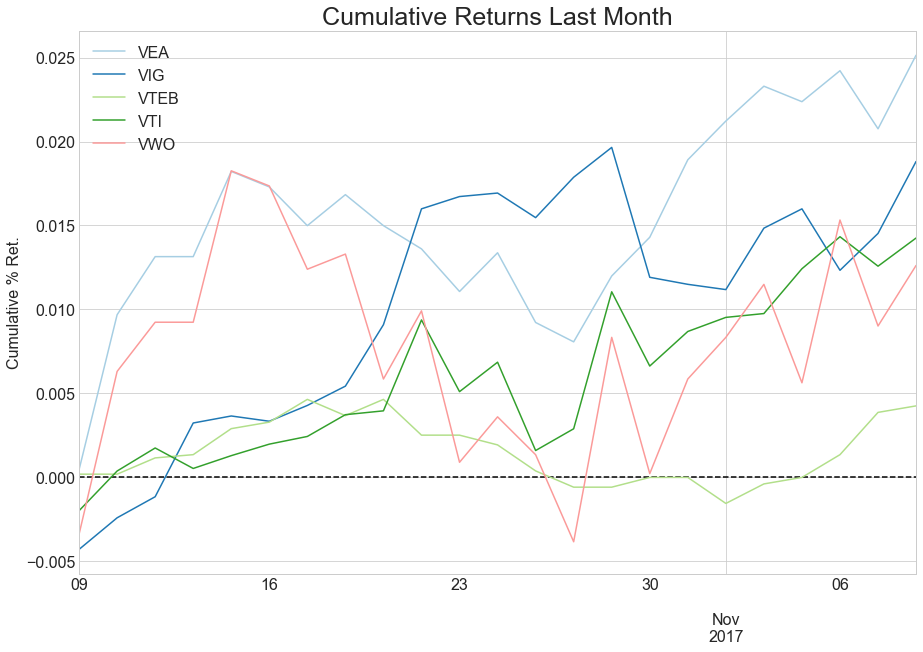

In [4]:
size = 5

winners = dfs[dfs['date'] == '20171006'].sort_values('cum_ret', ascending=False).reset_index()
picks = winners['name'].tolist()[:size]
win_df = dfs[(dfs['name'].isin(picks)) & (dfs['date'] > '20171006')]

fig, ax = plt.subplots()
month_ret = 0
for name, data in win_df.groupby('name'):
    data.sort_values('date', inplace=True)
    data['cum_ret'] = (1 + data['ret']).cumprod() - 1
    month_ret += data['cum_ret'].tail(1).tolist()[0]
    data.set_index('date')['cum_ret'].plot(ax=ax, alpha=1, label=name)
    
ax.hlines(0, data['date'].min(), data['date'].max(), linestyle='dashed')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Cumulative % Ret.')
ax.set_title('Cumulative Returns Last Month', size=25)

print 'Picks: %s' %', '.join(picks)
print 'Average monthly return: %.2f%%.' %(month_ret / size * 100)

winners

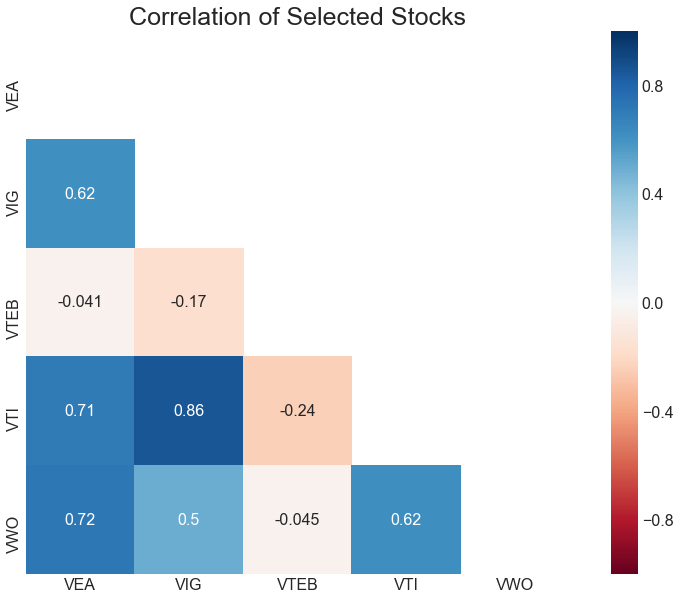

In [5]:
## Correlations
fig, ax = plt.subplots()

rets_df = dfs[dfs['name'].isin(picks)].pivot_table(index='date', columns='name', values='ret')
corr = rets_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='RdBu', vmin=-1, vmax=1, square=True, annot=True, ax=ax)
ax.set_title('Correlation of Selected Stocks', size=25)
ax.set_xlabel('')
ax.set_ylabel('');